### Mục đích: Xây dựng mô hình dự đoán phim có thành công hay không dựa trên dữ liệu 2 năm gần nhất. Các nhà làm phim sẽ theo dõi và học tập từ những bộ phim thành công để có thể xây dựng phương hướng phát triển cho năm tới.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [3]:
file_path = '../../Data/movie_data.csv'
movie_data = pd.read_csv(file_path)
movie_data.head()

,Title,Release time,Age rating,Runtime,Language,IMDb Rating,IMDb Votes,Action,Adventure,Animation,...,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,Win,Nomination,Age rating quantification
0,Goon Squad,2024-01-18,NC-17,83.0,English,6.1,12215.766268,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,5
1,The Phantom Warrior,2024-02-20,R,83.0,English,2.6,532.000000,False,True,False,...,False,True,False,False,False,False,False,0.0,0.0,4
2,Beyond the Lake,2024-01-26,G,98.0,English,6.1,31.000000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,1
3,Crimes of Fashion: Killer Clutch,2024-03-15,PG,84.0,"English, French",5.8,503.000000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,2
4,Love on the Danube: Love Song,2024-09-10,G,84.0,English,5.8,175.000000,False,False,False,...,True,False,False,False,False,False,False,0.0,0.0,1


In [4]:
movie_data_cleaned = movie_data.dropna()

# Tạo nhãn "Thành công" dựa trên IMDb Rating (giả định: thành công nếu IMDb > 7.0)
movie_data_cleaned['Success'] = (movie_data_cleaned['IMDb Rating'] > 7.0).astype(int)

features = ['Runtime', 'Age rating quantification', 'IMDb Votes', 
             'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western' ]

X = movie_data_cleaned[features]
y = movie_data_cleaned['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Xử lý dữ liệu mất cân bằng bằng SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Huấn luyện mô hình Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8070866141732284
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       431
           1       0.38      0.43      0.40        77

    accuracy                           0.81       508
   macro avg       0.64      0.65      0.64       508
weighted avg       0.82      0.81      0.81       508



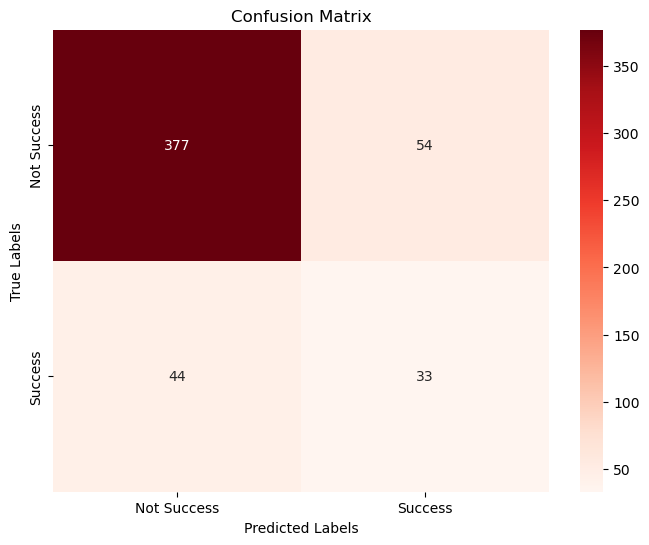

In [5]:
# 1. Trực quan hóa Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred, labels=["Not Success", "Success"])

1. Tỷ lệ nhận diện "Thành công" (Success) thấp:
- Mô hình chỉ dự đoán chính xác 33 trong tổng số 77 trường hợp "Thành công", thể hiện khả năng nhận diện lớp này còn yếu.
- Recall cho lớp "Thành công" thấp (khoảng 40%).
2. Mất cân bằng dữ liệu:
- Số lượng "Không thành công" lớn hơn nhiều so với "Thành công". Điều này ảnh hưởng đến khả năng học của mô hình, dẫn đến thiên lệch về lớp "Không thành công".

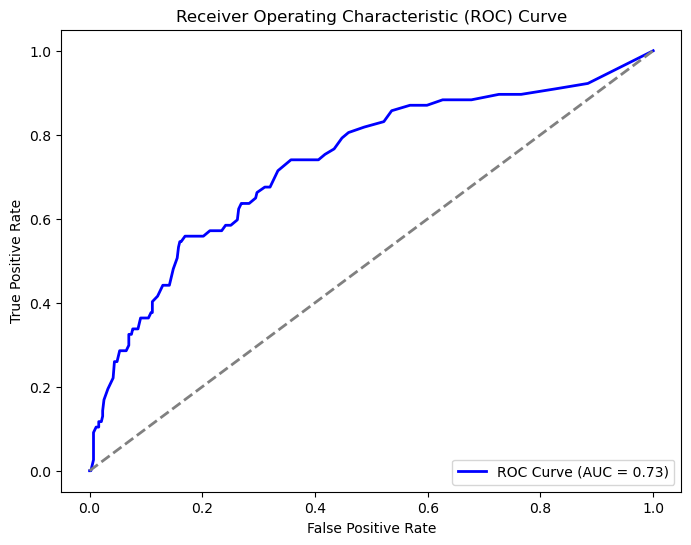

In [7]:
# 2. Trực quan hóa ROC Curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Dự đoán xác suất cho lớp 1 (Success)
y_pred_prob = model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_prob)

1. AUC Score = 0.73:
- Chỉ số AUC = 0.73 cho thấy mô hình có khả năng phân biệt giữa lớp "Thành công" và "Không thành công" nhưng chưa thực sự tối ưu.
- Mô hình tốt sẽ có AUC > 0.8.

2. Đường cong ROC:
- Đường cong nằm trên đường chéo (đường nét đứt) cho thấy mô hình có hiệu suất tốt hơn ngẫu nhiên.
- Tuy nhiên, khoảng cách giữa đường ROC và đường chéo không lớn, đặc biệt ở phần đầu, cho thấy mô hình vẫn bỏ lỡ một số dự đoán dương tính.

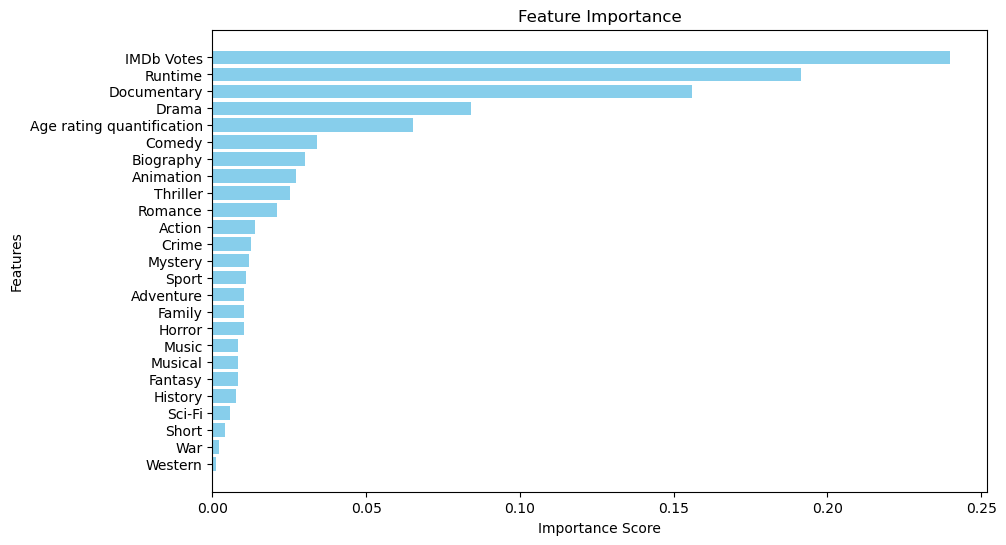

In [9]:
# 3. Trực quan hóa Feature Importance
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]
    sorted_importance = importance[sorted_idx]
    sorted_features = [feature_names[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  
    plt.show()

plot_feature_importance(model, features)

1. Đặc trưng quan trọng nhất:
- IMDb Votes (Số lượt bình chọn): có tầm ảnh hưởng lớn nhất đối với kết quả dự đoán của mô hình. Điều này hợp lý vì lượt bình chọn thường phản ánh mức độ quan tâm và yêu thích của khán giả đối với bộ phim, từ đó ảnh hưởng lớn đến khả năng thành công.

2. Các đặc trưng khác:
- Runtime (Thời lượng phim): cũng ảnh hưởng đáng kể. Điều này cho thấy thời lượng phim có thể tác động đến thị hiếu khán giả.
- Documentary và Drama: Thể loại phim tài liệu và phim chính kịch có mức độ ảnh hưởng cao, chứng tỏ đây là các thể loại thường thu hút sự quan tâm và có khả năng thành công cao.
- Age rating quantification (Xếp hạng độ tuổi): Cũng là một yếu tố quan trọng, gợi ý rằng độ tuổi hướng đến có thể ảnh hưởng đến thành công của phim.

3. Đặc trưng ít quan trọng:
- Các thể loại như Sci-Fi, Short, War, và Western có Importance Score rất thấp, cho thấy chúng ít ảnh hưởng đến khả năng dự đoán thành công của mô hình.

=> Biểu đồ Feature Importance cho thấy mô hình dựa nhiều vào IMDb Votes và Runtime để đưa ra dự đoán. Điều này hợp lý vì chúng có thể đo lường trực tiếp sự quan tâm của khán giả và mức độ thu hút của bộ phim.